<a href="https://colab.research.google.com/github/madhes23/deep_learning/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from enum import Enum

# Importing and plotting samples

In [9]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

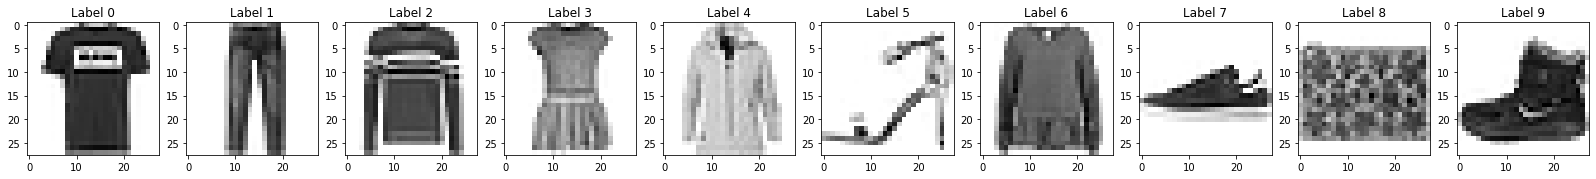

In [10]:
no_of_items = 10

fig, axes = plt.subplots(nrows = 1, ncols=10, figsize = (28, 28))
for item in range(no_of_items):
  index = 0
  while(y_train[index] != item): #searching for the first occurance of the element
    index = index+1
  
  ax = axes[item]
  ax.imshow(x_train[index], cmap='gray_r')
  ax.set_title('Label {}'.format(item))

# Reshaping the data for nerual network


In [11]:
no_of_pixels = x_train[0].size
x_train = x_train.reshape(-1, no_of_pixels)/255
x_test = x_test.reshape(-1, no_of_pixels)/255

# Some Utility functions

In [12]:
class ActivationFunction(Enum):
  SIGMOID = 1
  RELU = 2
  TAN_H = 3

class InitializationMethod(Enum):
  UNIFORM_RANDOM = 1
  UNIFORM_XAVIER = 2
  GAUSSIAN_XAVIER = 3

class OutputFunction(Enum):
  SOFTMAX = 1
  SQUARE_ERROR = 2

class Algorithm(Enum):
  GD = 1
  SGD = 2
  MOMENTUM_GD = 3

# Forward Propogation

In [13]:
class Classification:
  no_of_class = None
  hidden_layer = None
  input_layer = None
  activation_func = None
  output_func = None
  initialization_method = None
  max_epoch = None
  learning_rate = None
  weight = []
  bias = []
  def __init__(self, _no_of_class, _hidden_layer, _input_layer, _max_epoch, _activation_fun=ActivationFunction.RELU, _initialization_method=InitializationMethod.UNIFORM_XAVIER, _output_function = OutputFunction.SOFTMAX, _learning_rate = 0.01) -> None:
    self.no_of_class = _no_of_class
    self.hidden_layer = _hidden_layer
    self.activation_func = _activation_fun
    self.max_epoch = _max_epoch
    self.input_layer = _input_layer
    self.output_func = _output_function
    self.learning_rate = _learning_rate
    self.initialization_method = _initialization_method


  def set_weight_and_bias(self):
    #appending all these in a single list (easy for initializing w and b)
    layer = [self.input_layer]
    layer = layer + self.hidden_layer
    layer.append(self.no_of_class)

    #going to use 1-based indexing (as tought in the class)
    #so adding some random matrix in 0-th index
    w = [np.random.rand(1,1)]
    b = [np.random.rand(1,1)]
    if(self.initialization_method == InitializationMethod.UNIFORM_RANDOM): 
      low = -1
      high = 1
      i = 1
      while i < len(layer):
        w.append(np.random.uniform(low, high, size=(layer[i], layer[i-1])))
        # b.append(np.random.normal(mu, sigma, size=(layer[i])))
        b.append(np.zeros(layer[i]))
        i +=1
    
    if(self.initialization_method == InitializationMethod.UNIFORM_XAVIER): 
      for i in range(1, len(layer)):
        inputs = layer[i-1]
        outputs = layer[i]
        # x = math.sqrt(6/ inputs+outputs)
        x = math.sqrt(1/inputs)
        w.append(np.random.uniform(low=-x, high=x, size=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))

    if(self.initialization_method == InitializationMethod.GAUSSIAN_XAVIER): 
      mu = 0.0
      for i in range(1, len(layer)):
        inputs = layer[i-1]
        outputs = layer[i]
        # sigma = math.sqrt(6 / inputs+outputs)
        sigma = math.sqrt(1/ inputs)
        w.append(np.random.normal(mu, sigma, size=(layer[i], layer[i-1])))
        b.append(np.zeros(layer[i]))

    return w, b


  def activation_function(self, a):
    if(self.activation_func == ActivationFunction.SIGMOID):     #sigmoid
      res = []
      for i in a:
        if(i<0):
          res.append(math.exp(i) / (1 + math.exp(i)))
        else:
          res.append(1 / (1 + math.exp(-i)))
      return np.array(res)


  def df_activation_function(self, a):
    if(self.activation_func == ActivationFunction.SIGMOID): #sigmoid
      return self.activation_function(a) * (1 - self.activation_function(a))


  def output_function(self, a):
    if(self.output_func == OutputFunction.SOFTMAX): 
      a = a - np.max(a)
      return np.exp(a)/np.exp(a).sum()


  def forward_propogation(self, input):
    #for using 1 based indexing, adding some random matrix in 0-th index
    a = [np.random.rand(1,1)]
    h = [input]
    a.append(self.bias[1] + np.dot(self.weight[1], input))
    
    i = 1
    while i <= len(self.hidden_layer):
      h.append(self.activation_function(a[i])) #calculating h[i]
      a.append(self.bias[i+1] + np.dot(self.weight[i+1], h[i])) #calculating a[i+1]
      i +=1
    h.append(self.output_function(a[-1]))

    return a, h


  def backward_propogation(self, a, h, true_label):
    number_of_layers = len(a)-1 #including the output layer, excluding input layer
    del_a = [None] * (number_of_layers+1)
    del_h = [None] * (number_of_layers+1)
    del_w = [None] * (number_of_layers+1)
    del_b = [None] * (number_of_layers+1)
    
    #computing del_a_l
    del_a[-1] = h[-1]
    del_a[-1][true_label] -= 1

    for k in range(number_of_layers, 0, -1):
      #computing gradients w.r.t parameters
      del_w[k] = np.dot(del_a[k].reshape(-1,1), h[k-1].reshape(1, -1))
      del_b[k] = del_a[k]

      #computing gradients w.r.t layer below (post-activation)
      del_h[k-1] = np.dot(self.weight[k].T, del_a[k])

      #computing gradients w.r.t layer below (pre-activation)
      del_a[k-1] = del_h[k-1] * self.df_activation_function(a[k-1])
    
    #setting the 0-th index to some random array of (1,1)
    #so that it won't cause dimention mismatch
    del_w[0] = np.random.rand(1,1)
    del_b[0] = np.random.rand(1,1)
    return np.array(del_w, dtype=object), np.array(del_b, dtype=object)


  def test_i(self, x_test, give_activations=True):
    a, h = self.forward_propogation(x_test)
    if(give_activations):
      return a, h
    return np.argmax(h[-1])


  def calc_error(self, x, y):
    error = 0
    for i in range(len(x)):
      a, h = self.test_i(x[i], give_activations = True)
      true_label = y[i]
      error -= math.log(h[-1][true_label])
    return error/len(x)


  def fit(self, x_train, y_train): 
    # self.weight, self.bias = self.set_weight_and_bias()

    for i in range(self.max_epoch):
      tot_del_w = np.array([], dtype=object) #creating empty arrays
      tot_del_b = np.array([], dtype=object)
      for j in range(len(x_train)):
        a, h = self.forward_propogation(x_train[j])
        del_w, del_b = self.backward_propogation(a, h, y_train[j])

        if(tot_del_w.size == 0): 
          tot_del_w = del_w
          tot_del_b = del_b
        else:
          tot_del_w += del_w
          tot_del_b += del_b

      # tot_del_w /= len(x_train)
      # tot_del_b /= len(x_train)

      self.weight -= self.learning_rate * tot_del_w
      self.bias -= self.learning_rate * tot_del_b
      err = self.calc_error(x_train, y_train)
      print("Completed epoch : {} \t Error value: {}".format(i, err))



  def test(self, x_test, y_test):
    correct = 0
    for i in range(len(x_test)):
      if(y_test[i] == self.test_i(x_test[i], give_activations=False)):
        correct += 1
    
    return correct / len(x_test)

In [14]:
model = Classification(_no_of_class=10, 
                       _hidden_layer=[16, 16], 
                       _input_layer=784,
                       _initialization_method=InitializationMethod.UNIFORM_XAVIER,
                       _learning_rate=0.01,
                       _activation_fun=ActivationFunction.SIGMOID, 
                       _max_epoch=2000)
model.weight, model.bias = model.set_weight_and_bias()

model.fit(x_train[:100], y_train[:100])


print(y_train[0])
a, h = model.forward_propogation(x_train[0])
print(h[-1])

print(y_train[1])
a, h = model.forward_propogation(x_train[1])
print(h[-1])

print(y_train[5])
a, h = model.forward_propogation(x_train[5])
print(h[-1])

print(y_train[6])
a, h = model.forward_propogation(x_train[6])
print(h[-1])

<ipython-input-13-4996b85b5101>:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weight -= self.learning_rate * tot_del_w
<ipython-input-13-4996b85b5101>:169: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.bias -= self.learning_rate * tot_del_b


Completed epoch : 0 	 Error value: 2.280905465390955
Completed epoch : 1 	 Error value: 2.267059004894912
Completed epoch : 2 	 Error value: 2.262124971736719
Completed epoch : 3 	 Error value: 2.2596053976377437
Completed epoch : 4 	 Error value: 2.2578252370533387
Completed epoch : 5 	 Error value: 2.2563093975935478
Completed epoch : 6 	 Error value: 2.2548931500445084
Completed epoch : 7 	 Error value: 2.2535036048686155
Completed epoch : 8 	 Error value: 2.252100431042787
Completed epoch : 9 	 Error value: 2.2506566131389167
Completed epoch : 10 	 Error value: 2.2491508679932464
Completed epoch : 11 	 Error value: 2.247564142225834
Completed epoch : 12 	 Error value: 2.2458777895052604
Completed epoch : 13 	 Error value: 2.244072516112484
Completed epoch : 14 	 Error value: 2.2421276917813535
Completed epoch : 15 	 Error value: 2.240020825330283
Completed epoch : 16 	 Error value: 2.237727095945458
Completed epoch : 17 	 Error value: 2.2352188780471782
Completed epoch : 18 	 Error

KeyboardInterrupt: ignored